In [ ]:
!pip install -q scikit-learn sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import prune
import random

class SharedCore(nn.Module):
    def __init__(self):
        super(SharedCore, self).__init__()
        self.shared = nn.Linear(10, 8)

    def forward(self, x):
        return F.relu(self.shared(x))

class RoomAdapter(nn.Module):
    def __init__(self, shared_core):
        super(RoomAdapter, self).__init__()
        self.shared_core = shared_core
        self.adapter = nn.Linear(8, 1)

    def forward(self, x):
        x = self.shared_core(x)
        return self.adapter(x)


In [ ]:
def generate_data(task):
    x = torch.rand(100, 10)
    if task == "football":
        y = x.sum(dim=1, keepdim=True) * 2
    elif task == "cook":
        y = x.mean(dim=1, keepdim=True) * 3
    elif task == "study":
        y = x[:, 0:1] * 5
    elif task == "capital":
        y = x[:, 1:2] * 4
    elif task == "chess":
        y = x[:, 2:3] * 6
    elif task == "yoga":
        y = x[:, 3:4] * 2
    elif task == "invest":
        y = x[:, 4:5] * 1.5
    elif task == "poem":
        y = x[:, 5:6] * 7
    elif task == "python_java":
        y = x[:, 6:7] * 0.5
    elif task == "nset":
        y = x[:, 7:8] * 3.5
    return x, y

task_list = ["football", "cook", "study", "capital", "chess", "yoga", "invest", "poem", "python_java", "nset"]


In [ ]:
def train_and_compress_room(shared, task, epochs=200):
    model = RoomAdapter(shared)
    x, y = generate_data(task)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Room Compression
    prune.l1_unstructured(model.adapter, name='weight', amount=0.4)
    return model


In [ ]:
def room_selector(user_input):
    input_lower = user_input.lower()
    for task in task_list:
        if task in input_lower:
            return task
    return random.choice(task_list)  # fallback


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(shared_core, tasks):
    x_all = []
    labels = []

    for task in tasks:
        x, _ = generate_data(task)
        x_embed = shared_core(x).detach()
        x_all.append(x_embed)
        labels.extend([task] * len(x_embed))

    x_all = torch.cat(x_all).numpy()

    tsne = TSNE(n_components=2, random_state=42)
    x_2d = tsne.fit_transform(x_all)

    plt.figure(figsize=(10, 7))
    for task in tasks:
        idx = [i for i, label in enumerate(labels) if label == task]
        plt.scatter(x_2d[idx, 0], x_2d[idx, 1], label=task)
    plt.legend()
    plt.title("MoL Room Embeddings via t-SNE")
    plt.grid(True)
    plt.show()


In [ ]:
shared_core = SharedCore()
room_bank = {}

for task in task_list:
    print(f"Training room for task: {task}")
    room = train_and_compress_room(shared_core, task)
    room_bank[task] = room


Training room for task: football
Training room for task: cook
Training room for task: study
Training room for task: capital
Training room for task: chess
Training room for task: yoga
Training room for task: invest
Training room for task: poem
Training room for task: python_java
Training room for task: nset


In [ ]:
# Predict on user input
def predict(user_input):
    task = room_selector(user_input)
    model = room_bank[task]
    x_test, _ = generate_data(task)
    with torch.no_grad():
        pred = model(x_test[:1])
    print(f"🧠 Routed to: {task} | Prediction: {pred.item():.2f}")

# Try sample inputs
predict("How do I play football?")
predict("Help me cook something.")
predict("Best way to study?")
predict("Capital of Australia?")
predict("Chess opening strategies?")
predict("Yoga for stress")
predict("Start investing tips")
predict("Poem about stars")
predict("Python vs Java difference")
predict("NSET exam tips")


🧠 Routed to: football | Prediction: 4.33
🧠 Routed to: cook | Prediction: 0.05
🧠 Routed to: study | Prediction: 1.84
🧠 Routed to: capital | Prediction: 2.05
🧠 Routed to: chess | Prediction: 0.57
🧠 Routed to: yoga | Prediction: 0.81
🧠 Routed to: invest | Prediction: 1.93
🧠 Routed to: poem | Prediction: 2.23
🧠 Routed to: chess | Prediction: 0.57
🧠 Routed to: nset | Prediction: 2.29


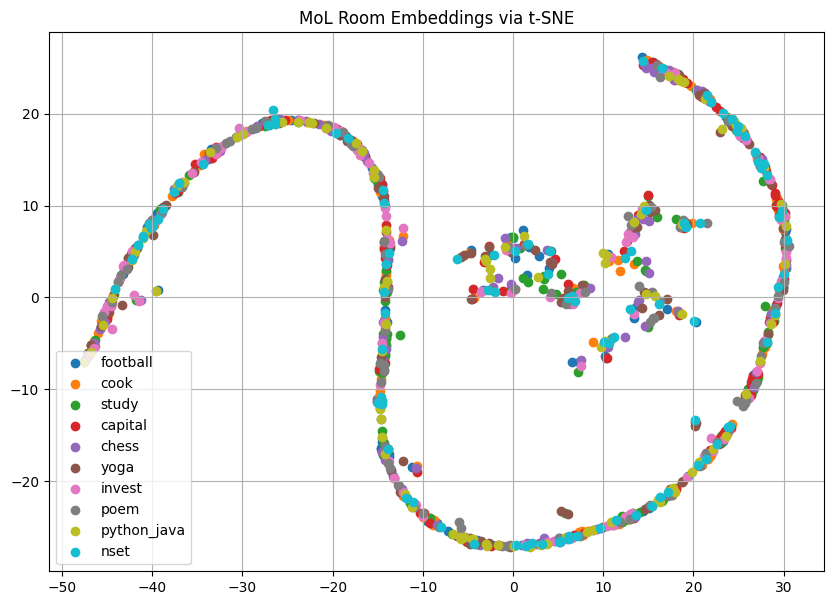

In [ ]:
visualize_embeddings(shared_core, task_list)
